 After your finish the assignment, remember to run all cells and save the note book to your local machine as a PDF for gradescope submission by pressing Ctrl-P or Cmd-P. Make sure images are not split between pages; insert Text blocks to make sure this is the case before printing to PDF!

List your collaborators here:



---



# **16720 HW 3: 3D Reconstruction**

# Problem 1: Theory

## 1.1
See pdf for the question.




# ===== your answer here for 1.1! =====

 Let  F  be the fundamental matrix between the two cameras. The fundamental matrix satisfies the epipolar constraint:
 $$

x{\prime}^T F x = 0

$$

where  $x$  and  $x{\prime}$  are the homogeneous coordinates of the point  X  in the first and second image planes, respectively.

Since  X  projects to the origin in both images, we have:

$$
x = \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}, \quad x{\prime} = \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}
$$

Substitute  $x$  and  $x{\prime}$  into the epipolar constraint:

$$
x{\prime}^T F x = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix} F \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}
$$

When we perform the matrix multiplication, we get:

$$
x{\prime}^T F x = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} f_{31} \\ f_{32} \\ f_{33} \end{bmatrix} = f_{33}
$$

The epipolar constraint tells us that  $x{\prime}^T F x = 0$. Therefore:

$$
f_{33} = 0
$$

# ===== end of your answer for 1.1 =====

##1.2
See pdf for the question.


# ===== your answer here for 1.2! =====

Suppose at time  i , the robot’s absolute rotation and translation are represented by  $R_i$  and  $t_i$ . Similarly, at time  i+1 , the robot’s absolute rotation and translation are  $R_{i+1}$  and  $t_{i+1}$ .

The relative rotation  $R_{\text{rel}}$  and relative translation  $t_{\text{rel}}$  between time  i  and  i+1  can be derived as follows. The relative rotation from time  i  to  i+1  is the rotation required to transform the orientation at time  i  to the orientation at time  i+1 . This can be expressed as:
$$
R_{\text{rel}} = R_{i+1} R_i^{-1}
$$
This equation essentially says that  $R_{\text{rel}}$  is the rotation that, when applied to the orientation at time  i , aligns it with the orientation at time  i+1 . The relative translation from time  i  to  i+1  is the vector from the position of the robot at time  i  to the position of the robot at time  i+1 , expressed in the coordinate frame at time  i+1 . We can calculate it as:
$$
t_{\text{rel}} = R_{i+1} (t_{i+1} - t_i)
$$
This represents the translation vector that takes the position at time  i  to the position at time  i+1 , transformed into the frame of reference at  i+1 .

The essential matrix  E  encodes the relative rotation and translation between two views up to scale. Given the relative rotation  $R_{\text{rel}}$  and relative translation  $t_{\text{rel}}$ , the essential matrix can be written as:

$$
E = [t_{\text{rel}}]_\times R{\text{rel}}
$$

where $[t_{\text{rel}}]_\times$  is the skew-symmetric matrix of the relative translation vector  $t{\text{rel}}$ , defined as:
$$
[t_{\text{rel}}]_\times = \begin{bmatrix} 0 & -t_z & t_y \ t_z & 0 & -t_x \ -t_y & t_x & 0 \end{bmatrix}
$$

In terms of the original parameters  $R_i$ ,  $R_{i+1}$ ,  $t_i$ , and  $t_{i+1}$ , we can substitute for  $R_{\text{rel}}$  and  $t_{\text{rel}}$  to express  E  as:

$$
E = [R_{i+1} (t_{i+1} - t_i)]\times R{i+1} R_i^{-1}
$$


The fundamental matrix  F  relates the two views in terms of pixel coordinates, taking into account the camera intrinsics  K . The relationship between the fundamental matrix and the essential matrix is given by:

$$
F = K^{-T} E K^{-1}
$$

Substituting the expression for  E :

$$
F = K^{-T} [R_{i+1} (t_{i+1} - t_i)]\times R{i+1} R_i^{-1} K^{-1}
$$

# ===== end of your answer for 1.2 =====

# **Coding**

## **Initialization**

Run the following code, which imports the modules you'll need and defines helper functions you may need to use later in your implementations.

In [1]:
import os
import numpy as np
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2


connections_3d = [[0,1], [1,3], [2,3], [2,0], [4,5], [6,7], [8,9], [9,11], [10,11], [10,8], [0,4], [4,8],
                  [1,5], [5,9], [2,6], [6,10], [3,7], [7,11]]
color_links = [(255,0,0),(255,0,0),(255,0,0),(255,0,0),(0,0,255),(255,0,255),(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,0,255),(0,0,255),(0,0,255),(0,0,255),(255,0,255),(255,0,255),(255,0,255),(255,0,255)]
colors = ['blue','blue','blue','blue','red','magenta','green','green','green','green','red','red','red','red','magenta','magenta','magenta','magenta']


def visualize_keypoints(image, pts, Threshold=100):
    '''
    This function visualizes the 2d keypoint pairs in connections_3d
    (as define above) whose match score lies above a given Threshold
    in an OpenCV GUI frame, against an image background.

    :param image: image as a numpy array, of shape (height, width, 3) where 3 is the number of color channels
    :param pts: np.array of shape (num_points, 3)
    '''
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i in range(12):
        cx, cy = pts[i][0:2]
        if pts[i][2]>Threshold:
            cv2.circle(image,(int(cx),int(cy)),5,(0,255,255),5)

    for i in range(len(connections_3d)):
        idx0, idx1 = connections_3d[i]
        if pts[idx0][2]>Threshold and pts[idx1][2]>Threshold:
            x0, y0 = pts[idx0][0:2]
            x1, y1 = pts[idx1][0:2]
            cv2.line(image, (int(x0), int(y0)), (int(x1), int(y1)), color_links[i], 2)

    cv2.imshow("Display", image)

    return image


def plot_3d_keypoint(pts_3d):
    '''
    this function visualizes 3d keypoints on a matplotlib 3d axes

    :param pts_3d: np.array of shape (num_points, 3)
    '''
    fig = plt.figure()
    num_points = pts_3d.shape[0]
    ax = fig.add_subplot(111, projection='3d')
    for j in range(len(connections_3d)):
        index0, index1 = connections_3d[j]
        xline = [pts_3d[index0,0], pts_3d[index1,0]]
        yline = [pts_3d[index0,1], pts_3d[index1,1]]
        zline = [pts_3d[index0,2], pts_3d[index1,2]]
        ax.plot(xline, yline, zline, color=colors[j])
    np.set_printoptions(threshold=1e6, suppress=True)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()


def calc_epi_error(pts1_homo, pts2_homo, F):
    '''
    Helper function to calcualte the sum of squared distance between the
    corresponding points and the estimated epipolar lines.

    pts1_homo \dot F.T \dot pts2_homo = 0

    :param pts1_homo: of shape (num_points, 3); in homogeneous coordinates, not normalized.
    :param pts2_homo: same specification as to pts1_homo.
    :param F: Fundamental matrix
    '''

    line1s = pts1_homo.dot(F.T)
    dist1 = np.square(np.divide(np.sum(np.multiply(
        line1s, pts2_homo), axis=1), np.linalg.norm(line1s[:, :2], axis=1)))

    line2s = pts2_homo.dot(F)
    dist2 = np.square(np.divide(np.sum(np.multiply(
        line2s, pts1_homo), axis=1), np.linalg.norm(line2s[:, :2], axis=1)))

    ress = (dist1 + dist2).flatten()
    return ress


def toHomogenous(pts):
    """
    Adds a stack of ones at the end, to turn a set of points into a set of
    homogeneous points.

    :params pts: in shape (num_points, 2).
    """
    return np.vstack([pts[:,0],pts[:,1],np.ones(pts.shape[0])]).T.copy()


def _epipoles(E):
    """
    gets the epipoles from the Essential Matrix.

    :params E: Essential matrix.
    """
    U, S, V = np.linalg.svd(E)
    e1 = V[-1, :]
    U, S, V = np.linalg.svd(E.T)
    e2 = V[-1, :]
    return e1, e2


def displayEpipolarF(I1, I2, F, points):
    """
    GUI interface you may use to help you verify your calculated fundamental
    matrix F. Select a point I1 in one view, and it should correctly correspond
    to the displayed point in the second view.
    """
    e1, e2 = _epipoles(F)

    sy, sx, _ = I2.shape

    f, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 9))
    ax1.imshow(I1)
    ax1.set_title('The point you selected:')
    ax2.imshow(I2)
    ax2.set_title('Verify that the corresponding point \n is on the epipolar line in this image')

    plt.sca(ax1)

    colors = ['r','g','b','y','m','k']
    for i, out in enumerate(points):
      x, y = out #[0]

      xc = x
      yc = y
      v = np.array([xc, yc, 1])
      l = F.dot(v)
      s = np.sqrt(l[0]**2+l[1]**2)

      if s==0:
          print('Zero line vector in displayEpipolar')

      l = l/s

      if l[0] != 0:
          ye = sy-1
          ys = 0
          xe = -(l[1] * ye + l[2])/l[0]
          xs = -(l[1] * ys + l[2])/l[0]
      else:
          xe = sx-1
          xs = 0
          ye = -(l[0] * xe + l[2])/l[1]
          ys = -(l[0] * xs + l[2])/l[1]

      # plt.plot(x,y, '*', 'MarkerSize', 6, 'LineWidth', 2);
      ax1.plot(x, y, '*', markersize=6, linewidth=2, color=colors[i%len(colors)])
      ax2.plot([xs, xe], [ys, ye], linewidth=2, color=colors[i%len(colors)])
    plt.draw()


def _singularize(F):
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = U.dot(np.diag(S).dot(V))
    return F

def _objective_F(f, pts1, pts2):
    F = _singularize(f.reshape([3, 3]))
    num_points = pts1.shape[0]
    hpts1 = np.concatenate([pts1, np.ones([num_points, 1])], axis=1)
    hpts2 = np.concatenate([pts2, np.ones([num_points, 1])], axis=1)
    Fp1 = F.dot(hpts1.T)
    FTp2 = F.T.dot(hpts2.T)

    r = 0
    for fp1, fp2, hp2 in zip(Fp1.T, FTp2.T, hpts2):
        r += (hp2.dot(fp1))**2 * (1/(fp1[0]**2 + fp1[1]**2) + 1/(fp2[0]**2 + fp2[1]**2))
    return r

def refineF(F, pts1, pts2):
    f = scipy.optimize.fmin_powell(
        lambda x: _objective_F(x, pts1, pts2), F.reshape([-1]),
        maxiter=10000,
        maxfun=10000,
        disp=False
    )
    return _singularize(f.reshape([3, 3]))


# Used in 4.2 Epipolar Correspondence
def epipolarMatchGUI(I1, I2, F, points, epipolarCorrespondence):
    e1, e2 = _epipoles(F)

    sy, sx, _ = I2.shape

    f, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 9))
    ax1.imshow(I1)
    ax1.set_title('The point you selected:')
    ax2.imshow(I2)
    ax2.set_title('Verify that the corresponding point \n is on the epipolar line in this image \nand that the corresponding point matches')

    plt.sca(ax1)

    colors = ['r','g','b','y','m','k']

    for i, out in enumerate(points):
      x, y = out

      xc = int(x)
      yc = int(y)
      v = np.array([xc, yc, 1])
      l = F.dot(v)
      s = np.sqrt(l[0]**2+l[1]**2)

      if s==0:
          print('Zero line vector in displayEpipolar')

      l = l/s

      if l[0] != 0:
          ye = sy-1
          ys = 0
          xe = -(l[1] * ye + l[2])/l[0]
          xs = -(l[1] * ys + l[2])/l[0]
      else:
          xe = sx-1
          xs = 0
          ye = -(l[0] * xe + l[2])/l[1]
          ys = -(l[0] * xs + l[2])/l[1]

      ax1.plot(x, y, '*', markersize=6, linewidth=2, color=colors[i%len(colors)])
      ax2.plot([xs, xe], [ys, ye], linewidth=2, color=colors[i%len(colors)])

      # draw points
      x2, y2 = epipolarCorrespondence(I1, I2, F, xc, yc)
      ax2.plot(x2, y2, 'ro', markersize=8, linewidth=2)
      plt.draw()



## **Set up data**
In this section, we will download the test case image views, camera intrinsics, and point correnspondences, which you will use for testing your implementations.

In [2]:
if not os.path.exists('data'):
  !wget https://www.andrew.cmu.edu/user/eweng/data.zip -O data.zip
  !unzip -qq "data.zip"
  print("downloaded and unzipped data")

# Problem 2: Estimating the Fundamental Matrix with the Eight-point Algorithm

In this part, implement the 8-point algorithm you learned in class, which estimates the fundamental matrix from corresponding points in two images.

In [3]:
def eightpoint(pts1, pts2, M):
    '''
    Q2.1: Eight Point Algorithm
    Input:  pts1, Nx2 Matrix
            pts2, Nx2 Matrix
            M, a scalar parameter computed as max(imwidth, imheight)
    Output: F, the fundamental matrix

    HINTS:
    (1) Normalize the input pts1 and pts2 using the matrix T.
    (2) Setup the eight point algorithm's equation.
    (3) Solve for the least square solution using SVD.
    (4) Use the function `_singularize` (provided in the helper functions above) to enforce the singularity condition.
    (5) Use the function `refineF` (provided in the helper functions above) to refine the computed fundamental matrix.
        (Remember to use the normalized points instead of the original points)
    (6) Unscale the fundamental matrix by the lower right corner element
    '''
    
    # Step 1: Normalize points
    T = np.array([[1 / M, 0, 0],
                  [0, 1 / M, 0],
                  [0, 0, 1]])
    
    pts1_norm = np.hstack((pts1, np.ones((pts1.shape[0], 1)))) @ T.T
    pts2_norm = np.hstack((pts2, np.ones((pts2.shape[0], 1)))) @ T.T

    # Step 2: Construct matrix A for the eight-point algorithm
    A = np.zeros((pts1.shape[0], 9))
    for i in range(pts1.shape[0]):
        x1, y1 = pts1_norm[i, :2]
        x2, y2 = pts2_norm[i, :2]
        A[i] = [x1 * x2, y1 * x2, x2, x1 * y2, y1 * y2, y2, x1, y1, 1]

    # Step 3: Solve for F using SVD
    _, _, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3, 3)

    # Step 4: Enforce the rank-2 constraint on F
    F = _singularize(F)

    # Step 5: Refine the fundamental matrix
    F = refineF(F, pts1_norm[:, :2], pts2_norm[:, :2])

    # Step 6: Unscale F to get the denormalized fundamental matrix
    F = T.T @ F @ T

    # Normalize F such that F[2,2] is 1
    F = F / F[2, 2]

    return F

Run this code to test your implementation of the 8-point algorithm. Your code should pass all the assert statements at the end.

In [4]:
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1 = plt.imread('data/im1.png')
im2 = plt.imread('data/im2.png')

F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))
print(f'recovered F:\n{F.round(4)}')

# Simple Tests to verify your implementation:
pts1_homogenous, pts2_homogenous = toHomogenous(pts1), toHomogenous(pts2)

assert F.shape == (3, 3), "F is wrong shape"
assert F[2, 2] == 1, "F_33 != 1"
assert np.linalg.matrix_rank(F) == 2, "F should have rank 2"
assert np.mean(calc_epi_error(pts1_homogenous, pts2_homogenous, F)) < 1, "F error is too high to be accurate"

recovered F:
[[-0.      0.     -0.2519]
 [ 0.     -0.      0.0026]
 [ 0.2422 -0.0068  1.    ]]


The following tool may help you debug. You may specify a point in im1, and view the corresponding epipolar line in im2 based on the F you found. In your submission, make sure you include the debug picture below, with at least five epipolar point-line correspondences taht show that your calculation of F is correct.



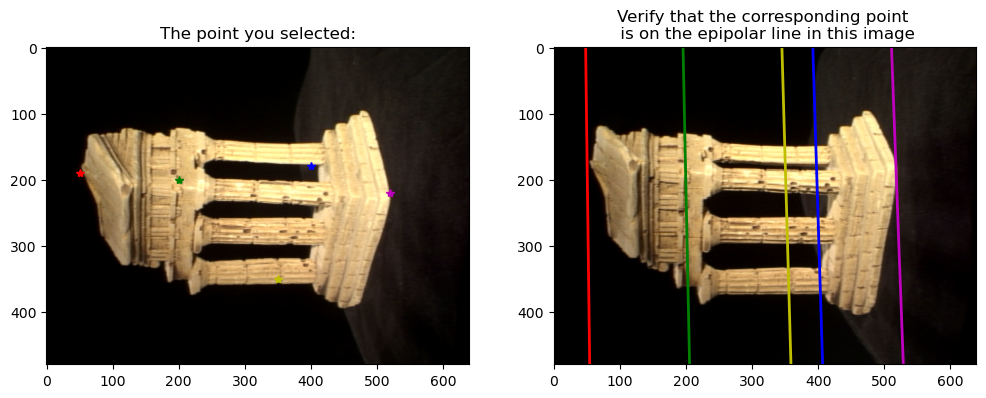

In [5]:
# the points in im1, whose correnponding epipolar line in im2 you'd like to verify
point = [(50,190),(200, 200), (400,180), (350,350), (520, 220)]
# feel free to change these point, to verify different point correspondences
displayEpipolarF(im1, im2, F, point)

# Problem 3: Metric Reconstruction

## 3.1 Essential Matrix

In [6]:
import numpy as np

def essentialMatrix(F, K1, K2):
    '''
    Q3.1: Compute the essential matrix E.
    Input:  F, fundamental matrix
            K1, internal camera calibration matrix of camera 1
            K2, internal camera calibration matrix of camera 2
    Output: E, the essential matrix
    '''

    # ----- TODO -----
    ### BEGIN SOLUTION

    # Compute the essential matrix E from F, K1, and K2
    E = np.matmul(np.matmul(K2.T, F), K1)
    E = E/E[2,2]
    ### END SOLUTION
    return E

Run the following code to check your implementation.

In [7]:
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1 = plt.imread('data/im1.png')
im2 = plt.imread('data/im2.png')

F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))
E = essentialMatrix(F, K1, K2)
print(f'recovered E:\n{E.round(4)}')

# Simple Tests to verify your implementation:
assert(E[2, 2] == 1)
assert(np.linalg.matrix_rank(E) == 2)

recovered E:
[[-3.3716000e+00  4.5661580e+02 -2.4738947e+03]
 [ 1.9760420e+02 -1.0290300e+01  6.4396600e+01]
 [ 2.4807427e+03  1.9856400e+01  1.0000000e+00]]


# 3.2 Triangulation


In [8]:
import numpy as np

def triangulate(C1, pts1, C2, pts2):
    '''
    Q3.2: Triangulate a set of 2D coordinates in the image to a set of 3D points.
    Input:  C1, the 3x4 camera matrix
            pts1, the Nx2 matrix with the 2D image coordinates per row
            C2, the 3x4 camera matrix
            pts2, the Nx2 matrix with the 2D image coordinates per row
    Output: P, the Nx3 matrix with the corresponding 3D points per row
            err, the reprojection error.

    Hints:
    (1) For every input point, form A using the corresponding points from pts1 & pts2 and C1 & C2
    (2) Solve for the least square solution using np.linalg.svd
    (3) Calculate the reprojection error using the calculated 3D points and C1 & C2 (do not forget to convert from
        homogeneous coordinates to non-homogeneous ones)
    (4) Keep track of the 3D points and projection error, and continue to next point
    (5) You do not need to follow the exact procedure above.
    '''
    N = pts1.shape[0]  # Number of points
    P = np.zeros((N, 3))  # Nx3 matrix to store 3D points
    err = 0  # Variable to store the cumulative reprojection error

    for i in range(N):
        # (1) Formulate matrix A for each pair of points
        x1, y1 = pts1[i]
        x2, y2 = pts2[i]
        A = np.array([
            x1 * C1[2] - C1[0],
            y1 * C1[2] - C1[1],
            x2 * C2[2] - C2[0],
            y2 * C2[2] - C2[1]
        ])

        # (2) Solve for the least squares solution using SVD
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]
        X /= X[3]  # Normalize to make it a proper 3D point

        # Store the 3D point in P
        P[i] = X[:3]

        # (3) Calculate the reprojection error
        # Project the 3D point back to each camera
        p1_proj = C1 @ X  # Projected point in camera 1
        p2_proj = C2 @ X  # Projected point in camera 2

        # Convert from homogeneous to non-homogeneous coordinates
        p1_proj /= p1_proj[2]
        p2_proj /= p2_proj[2]

        # Calculate the reprojection error for each point
        err += np.sum((pts1[i] - p1_proj[:2])**2) + np.sum((pts2[i] - p2_proj[:2])**2)

    return P, err

## 3.3 Find M2

In [9]:
def camera2(E):
  """helper function to find the 4 possibile M2 matrices"""
  U,S,V = np.linalg.svd(E)
  m = S[:2].mean()
  E = U.dot(np.array([[m,0,0], [0,m,0], [0,0,0]])).dot(V)
  U,S,V = np.linalg.svd(E)
  W = np.array([[0,-1,0], [1,0,0], [0,0,1]])

  if np.linalg.det(U.dot(W).dot(V))<0:
      W = -W

  M2s = np.zeros([3,4,4])
  M2s[:,:,0] = np.concatenate([U.dot(W).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
  M2s[:,:,1] = np.concatenate([U.dot(W).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
  M2s[:,:,2] = np.concatenate([U.dot(W.T).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
  M2s[:,:,3] = np.concatenate([U.dot(W.T).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
  return M2s

def findM2(F, pts1, pts2, intrinsics):
    '''
    Q3.3: Function to find camera2's projective matrix given correspondences
        Input:  F, the pre-computed fundamental matrix
                pts1, the Nx2 matrix with the 2D image coordinates per row
                pts2, the Nx2 matrix with the 2D image coordinates per row
                intrinsics, the intrinsics of the cameras, load from the .npz file
        Output: [M2, C2, P] the computed M2 (3x4) camera projective matrix, C2 (3x4) K2 * M2, and the 3D points P (Nx3)

    Hints:
    (1) Loop through the 'M2s' and use triangulate to calculate the 3D points and projection error. Keep track
        of the projection error through best_error and retain the best one.
    (2) Remember to take a look at camera2 to see how to correctly retrieve the M2 matrix from 'M2s'.
    '''

    K1, K2 = intrinsics['K1'], intrinsics['K2']
    
    # Compute the Essential Matrix from F
    E = K2.T @ F @ K1

    # Get the four possible M2s using camera2 function
    M2_candidates = camera2(E)

    # Initial camera matrix for the first camera
    M1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    C1 = K1 @ M1

    best_error = float('inf')
    best_M2, best_C2, best_P = None, None, None

    # Loop through each possible M2 to find the best configuration
    for i in range(4):
        M2 = M2_candidates[:, :, i]
        C2 = K2 @ M2

        # Triangulate points with this configuration of M2
        P, error = triangulate(C1, pts1, C2, pts2)

        # Check if all points have positive depth (in front of both cameras)
        if np.all(P[:, 2] > 0) and error < best_error:
            best_error = error
            best_M2 = M2
            best_C2 = C2
            best_P = P

    return best_M2, best_C2, best_P

Run the following code to check your implementation of triangulation and findM2.

In [10]:
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1 = plt.imread('data/im1.png')
im2 = plt.imread('data/im2.png')

F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))


M2, C2, P = findM2(F, pts1, pts2, intrinsics)

# Simple Tests to verify your implementation:
M1 = np.hstack((np.identity(3), np.zeros(3)[:,np.newaxis]))
C1 = K1.dot(M1)
C2 = K2.dot(M2)
P_test, err = triangulate(C1, pts1, C2, pts2)
assert(err < 500)

# Problem 4: 3D Visualization

In [11]:
import numpy as np
from scipy.ndimage import gaussian_filter

def epipolarCorrespondence(im1, im2, F, x1, y1):
    '''
    Q4.1: Epipolar Correspondence for a point.
    Input:  im1, the first image
            im2, the second image
            F, the fundamental matrix
            x1, x-coordinates of a pixel on im1
            y1, y-coordinates of a pixel on im1
    Output: x2, y2, the coordinates of the pixel on im2
    '''

    # Parameters
    window_size = 5  # Half-size of the window to compare (window will be 2*window_size + 1)
    search_range = 50  # Range of search along the epipolar line

    # Convert (x1, y1) to homogeneous coordinates
    pt1 = np.array([x1, y1, 1])

    # Compute the epipolar line in the second image
    epipolar_line = F @ pt1  # l2 = [a, b, c] in line equation ax + by + c = 0

    # Normalize the line for numerical stability
    a, b, c = epipolar_line / np.sqrt(epipolar_line[0]**2 + epipolar_line[1]**2)

    # Extract the window from the first image centered at (x1, y1)
    window1 = im1[int(y1) - window_size:int(y1) + window_size + 1, int(x1) - window_size:int(x1) + window_size + 1]

    # Apply Gaussian weighting to the window
    gaussian_weight = gaussian_filter(np.ones_like(window1), sigma=1)
    window1 = window1 * gaussian_weight

    best_error = float('inf')
    best_x2, best_y2 = None, None

    # Search along the epipolar line in a range of [-search_range, search_range] in the y-direction
    for dy in range(-search_range, search_range + 1):
        # Calculate the corresponding y2
        y2 = int(y1 + dy)
        
        # Solve for x2 along the epipolar line using the line equation ax2 + by2 + c = 0
        x2 = int(round(-(b * y2 + c) / a))

        # Ensure x2, y2 are within bounds
        if x2 - window_size < 0 or x2 + window_size >= im2.shape[1] or y2 - window_size < 0 or y2 + window_size >= im2.shape[0]:
            continue

        # Extract the window from the second image centered at (x2, y2)
        window2 = im2[y2 - window_size:y2 + window_size + 1, x2 - window_size:x2 + window_size + 1]

        # Apply Gaussian weighting to window2
        window2 = window2 * gaussian_weight

        # Compute the SSD (sum of squared differences) between the windows
        ssd = np.sum((window1 - window2) ** 2)

        # Update if this is the best match
        if ssd < best_error:
            best_error = ssd
            best_x2, best_y2 = x2, y2

    return best_x2, best_y2

Run the following code to check your implementation.

In [12]:
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1 = plt.imread('data/im1.png')
im2 = plt.imread('data/im2.png')

F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))

# Simple Tests to verify your implementation:
x2, y2 = epipolarCorrespondence(im1, im2, F, 119, 217)
assert(np.linalg.norm(np.array([x2, y2]) - np.array([118, 181])) < 10)

Use the below tool to debug your code.

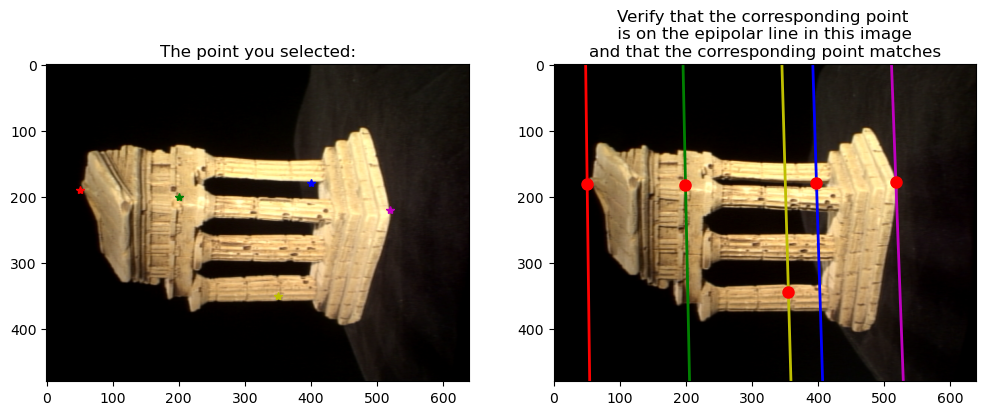

In [13]:
# the points in im1 whose correnponding epipolar line in im2 you'd like to verify
points = [(50,190), (200, 200), (400,180), (350,350), (520, 220)]
# feel free to change these points to verify different point correspondences
epipolarMatchGUI(im1, im2, F, points, epipolarCorrespondence)

##4.2 Temple Visualization

In [14]:
def compute3D_pts(temple_pts1, intrinsics, F, im1, im2):
    '''
    Q4.2: Finding the 3D position of given points based on epipolar correspondence and triangulation
    Input:  temple_pts1, chosen points from im1
            intrinsics, the intrinsics dictionary for calling epipolarCorrespondence
            F, the fundamental matrix
            im1, the first image
            im2, the second image
    Output: P (Nx3) the recovered 3D points
    '''
    
    # Initialize a list to store corresponding points in im2
    pts2 = []

    # Loop over each point in temple_pts1 to find the corresponding point in im2
    for pt1 in temple_pts1:
        x1, y1 = pt1[:2]  # Only use the x and y coordinates, ignore the homogeneous coordinate if present
        x2, y2 = epipolarCorrespondence(im1, im2, F, x1, y1)
        pts2.append([x2, y2])
    
    # Convert pts2 to a NumPy array for easier manipulation
    pts2 = np.array(pts2)

    # Retrieve intrinsic matrices
    K1, K2 = intrinsics['K1'], intrinsics['K2']

    # Use findM2 to get M2, C2, and triangulated points P
    M2, C2, P = findM2(F, temple_pts1[:, :2], pts2, intrinsics)

    return P

Below, integrate everything together.
The provided starter code loads in the temple data found at `data/templeCoords.npz`, which contains 288 hand-selected points from im1 saved in the variables x1 and y1.
Then, get the 3d points from the 2d point point correspondences by calling the function you just implemented, as well as other necessary function. Finally, visualize the 3D reconstruction using matplotlib or plotly 3d scatter plot.


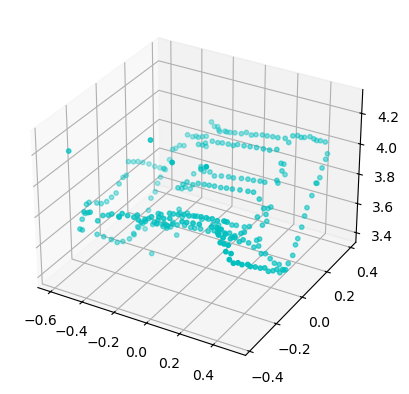

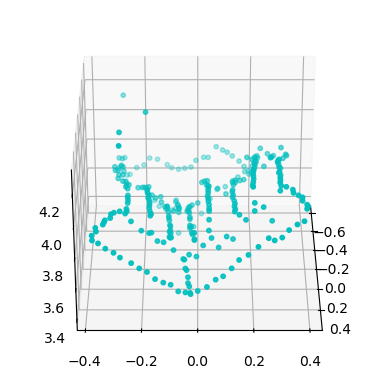

In [15]:
temple_coords = np.load('data/templeCoords.npz') # Loading temple coordinates
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1 = plt.imread('data/im1.png')
im2 = plt.imread('data/im2.png')

# ----- TODO -----
# Call eightpoint to get the F matrix
# Call compute3D_pts to get the 3D points and visualize using matplotlib scatter
# hint: you can change the viewpoint of a matplotlib 3d axes using
# `ax.view_init(azim, elev)` where azim is the rotation around the vertical z
# axis, and elev is the angle of elevation from the x-y plane

temple_pts1 = np.hstack([temple_coords['x1'], temple_coords['y1']])

# YOUR CODE HERE
# Calculate the scaling parameter M as max(imwidth, imheight)
M = max(im1.shape[0], im1.shape[1])

# Call eightpoint to compute the fundamental matrix F
F = eightpoint(pts1, pts2, M)

# Call compute3D_pts to get the 3D points P
P = compute3D_pts(temple_pts1, intrinsics, F, im1, im2)
# END YOUR CODE

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(P[:, 0], P[:, 1], P[:, 2], s=10, c='c', depthshade=True)
plt.draw()

# also show a different viewpoint
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(P[:, 0], P[:, 1], P[:, 2], s=10, c='c', depthshade=True)
ax.view_init(30, 0)
plt.draw()


# Problem 5: Bundle Adjustment

Below is the implementation of RANSAC for Fundamental Matrix Recovery.

In [16]:

def ransacF(pts1, pts2, M, nIters=100, tol=10):
  '''
  Input:  pts1, Nx2 Matrix
          pts2, Nx2 Matrix
          M, a scaler parameter
          nIters, Number of iterations of the Ransac
          tol, tolerence for inliers
  Output: F, the fundamental matrix
          inliers, Nx1 bool vector set to true for inliers

  '''
  N = pts1.shape[0]
  pts1_homo, pts2_homo = toHomogenous(pts1), toHomogenous(pts2)
  best_inlier = 0
  inlier_curr = None

  for i in range(nIters):
      choice = np.random.choice(range(pts1.shape[0]), 8)
      pts1_choice = pts1[choice, :]
      pts2_choice = pts2[choice, :]
      F = eightpoint(pts1_choice, pts2_choice, M)
      ress = calc_epi_error(pts1_homo, pts2_homo, F)
      curr_num_inliner = np.sum(ress < tol)
      if curr_num_inliner > best_inlier:
          F_curr = F
          inlier_curr = (ress < tol)
          best_inlier = curr_num_inliner
  inlier_curr = inlier_curr.reshape(inlier_curr.shape[0], 1)
  indixing_array = inlier_curr.flatten()
  pts1_inlier = pts1[indixing_array]
  pts2_inlier = pts2[indixing_array]
  F = eightpoint(pts1_inlier, pts2_inlier, M)
  return F, inlier_curr


Below is the implementation of Rodrigues and Inverse Rodrigues Formulas. See the pdf for the detailed explanation of the functions.

In [17]:
def rodrigues(r):
  '''
      Input:  r, a 3x1 vector
      Output: R, a rotation matrix
  '''

  r = np.array(r).flatten()
  I = np.eye(3)
  theta = np.linalg.norm(r)
  if theta == 0:
      return I
  else:
      U = (r/theta)[:, np.newaxis]
      Ux, Uy, Uz = r/theta
      K = np.array([[0, -Uz, Uy], [Uz, 0, -Ux], [-Uy, Ux, 0]])
      R = I * np.cos(theta) + np.sin(theta) * K + \
          (1 - np.cos(theta)) * np.matmul(U, U.T)
  return R


def invRodrigues(R):
  '''
  Input:  R, a rotation matrix
  Output: r, a 3x1 vector
  '''

  def s_half(r):
      r1, r2, r3 = r
      if np.linalg.norm(r) == np.pi and (r1 == r2 and r1 == 0 and r2 == 0 and r3 < 0) or (r1 == 0 and r2 < 0) or (r1 < 0):
          return -r
      else:
          return r

  A = (R - R.T)/2
  ro = [A[2, 1], A[0, 2], A[1, 0]]
  s = np.linalg.norm(ro)
  c = (np.sum(np.matrix(R).diagonal()) - 1)/2
  if s == 0 and c == 1:
      r = np.zeros(3)
  elif s == 0 and c == -1:
      col = np.eye(3) + R
      col_idx = np.nonzero(
          np.array(np.sum(col != 0, axis=0)).flatten())[0][0]
      v = col[:, col_idx]
      u = v/np.linalg.norm(v)
      r = s_half(u * np.pi)
  else:
      u = ro/s
      theta = np.arctan2(s, c)
      r = u * theta

  return r

### Rodrigues Residual objective function




In [18]:
def rodriguesResidual(K1, M1, p1, K2, p2, x):
    '''
    Q5.1: Rodrigues residual.
      Input:  K1, the intrinsics of camera 1
              M1, the extrinsics of camera 1
              p1, the 2D coordinates of points in image 1
              K2, the intrinsics of camera 2
              p2, the 2D coordinates of points in image 2
              x, the flattened concatenation of P, r2, and t2.
      Output: residuals, 4N x 1 vector, the difference between original and estimated projections
    '''
    
    N = p1.shape[0]
    
    # Extract P, r2, and t2 from x
    P = x[:3 * N].reshape((N, 3))  # 3D points P, shape (N, 3)
    r2 = x[3 * N:3 * N + 3]  # Rotation vector for camera 2, shape (3,)
    t2 = x[3 * N + 3:]  # Translation vector for camera 2, shape (3,)

    # Compute rotation matrix R2 from r2 using Rodrigues' formula
    R2 = rodrigues(r2)

    # Compute projection matrices C1 and C2
    C1 = K1 @ M1  # Projection matrix for camera 1
    M2 = np.hstack((R2, t2.reshape(3, 1)))  # Extrinsics for camera 2
    C2 = K2 @ M2  # Projection matrix for camera 2

    # Project 3D points P onto both images
    P_homogeneous = np.hstack((P, np.ones((N, 1))))  # Convert P to homogeneous coordinates
    
    # Project points onto image 1
    p1_proj_homogeneous = (C1 @ P_homogeneous.T).T  # Projected points in homogeneous coordinates
    p1_proj = (p1_proj_homogeneous[:, :2].T / p1_proj_homogeneous[:, 2]).T  # Convert to non-homogeneous coordinates

    # Project points onto image 2
    p2_proj_homogeneous = (C2 @ P_homogeneous.T).T  # Projected points in homogeneous coordinates
    p2_proj = (p2_proj_homogeneous[:, :2].T / p2_proj_homogeneous[:, 2]).T  # Convert to non-homogeneous coordinates

    # Calculate residuals as the difference between observed and projected points
    residuals_p1 = (p1 - p1_proj).reshape(-1)  # Difference for points in image 1
    residuals_p2 = (p2 - p2_proj).reshape(-1)  # Difference for points in image 2

    # Concatenate residuals for both images into a single 4N x 1 vector
    residuals = np.hstack((residuals_p1, residuals_p2)).reshape(-1, 1)

    return residuals

### Bundle Adjustment

In [19]:
import numpy as np
from scipy.optimize import minimize

def bundleAdjustment(K1, M1, p1, K2, M2_init, p2, P_init):
    '''
    Q5.2 Bundle adjustment.
    Input:  K1, the intrinsics of camera 1
            M1, the extrinsics of camera 1
            p1, the 2D coordinates of points in image 1
            K2, the intrinsics of camera 2
            M2_init, the initial extrinsics of camera 2
            p2, the 2D coordinates of points in image 2
            P_init, the initial 3D coordinates of points
    Output: M2, the optimized extrinsics of camera 2
            P, the optimized 3D coordinates of points
            obj_start, the starting objective function value with the initial input
            obj_end, the ending objective function value after bundle adjustment
    '''

    # Step 1: Convert M2_init to Rodrigues rotation vector and translation vector
    R2_init = M2_init[:, :3]
    t2_init = M2_init[:, 3]
    r2_init = invRodrigues(R2_init)

    # Step 2: Flatten the initial 3D points P_init, rotation vector r2_init, and translation t2_init
    x_init = np.hstack((P_init.flatten(), r2_init, t2_init))

    # Step 3: Define the objective function
    def objective_function(x):
        # Compute residuals using rodriguesResidual function
        residuals = rodriguesResidual(K1, M1, p1, K2, p2, x)
        return np.sum(residuals**2)  # Sum of squared residuals

    # Step 4: Calculate the initial objective function value (obj_start)
    obj_start = objective_function(x_init)

    # Step 5: Use scipy.optimize.minimize to optimize the parameters
    result = minimize(objective_function, x_init, method='L-BFGS-B')

    # Step 6: Calculate the final objective function value (obj_end)
    obj_end = result.fun

    # Step 7: Extract optimized parameters from result
    x_optimized = result.x
    P_optimized = x_optimized[:3 * P_init.shape[0]].reshape(P_init.shape)  # Optimized 3D points
    r2_optimized = x_optimized[3 * P_init.shape[0]:3 * P_init.shape[0] + 3]  # Optimized rotation vector
    t2_optimized = x_optimized[3 * P_init.shape[0] + 3:]  # Optimized translation vector

    # Step 8: Convert r2_optimized back to rotation matrix R2 using rodrigues function
    R2_optimized = rodrigues(r2_optimized)

    # Step 9: Construct optimized M2 from R2 and t2
    M2 = np.hstack((R2_optimized, t2_optimized.reshape(3, 1)))

    return M2, P_optimized, obj_start, obj_end

Put it all together

1. Call the ransacF function to find the fundamental matrix
2. Call the findM2 function to find the extrinsics of the second camera
3. Call the bundleAdjustment function to optimize the extrinsics and 3D points
4. Plot the 3D points before and after bundle adjustment using the plot_3D_dual function

On the given temple data, bundle adjustment can take up to 2 min to run.

In [36]:
# Visualization:
np.random.seed(1)
correspondence = np.load('data/some_corresp_noisy.npz') # Loading noisy correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1 = plt.imread('data/im1.png')
im2 = plt.imread('data/im2.png')
M=np.max([*im1.shape, *im2.shape])

# YOUR CODE HERE
'''
Call the ransacF function to find the fundamental matrix
Call the findM2 function to find the extrinsics of the second camera
Call the bundleAdjustment function to optimize the extrinsics and 3D points
'''
# Step 1: Use RANSAC to estimate the fundamental matrix F
F, inliers = ransacF(pts1, pts2, M, nIters=100, tol=20)

# Step 2: Use the inliers to find the second camera extrinsics
pts1_inliers = pts1[inliers.flatten()]
pts2_inliers = pts2[inliers.flatten()]
M2_init, C2, P_init = findM2(F, pts1_inliers, pts2_inliers, intrinsics)

# Step 3: Perform bundle adjustment to refine the 3D points and extrinsics
M1 = np.hstack((np.eye(3), np.zeros((3, 1))))  # Initial extrinsics for camera 1
obj_start, obj_end = None, None  # Initialize variables for initial and final reprojection errors
M2, P_final, obj_start, obj_end = bundleAdjustment(K1, M1, pts1_inliers, K2, M2_init, pts2_inliers, P_init)

# Step 4: Output the reprojection error before and after bundle adjustment
print(f"Before reprojection error: {obj_start}, After: {obj_end}")


Before reprojection error: 352.8418822004882, After: 32.50708720215517


: 

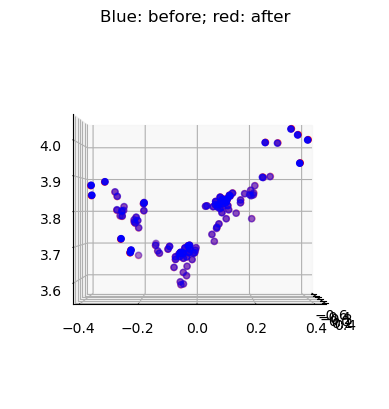

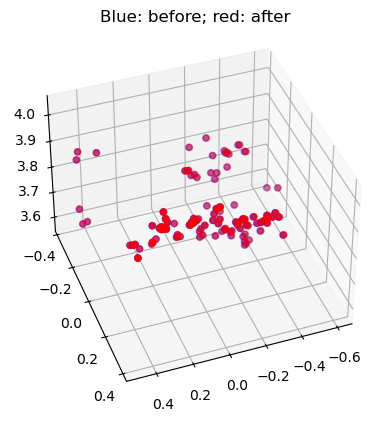

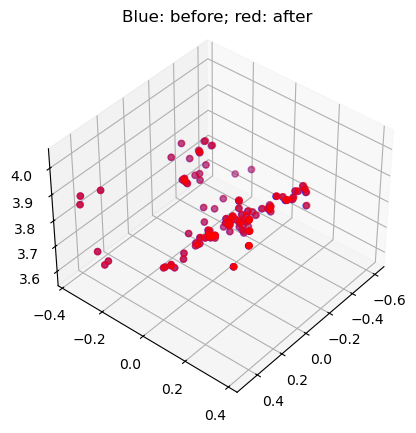

In [21]:
# helper function for visualization
def plot_3D_dual(P_before, P_after, azim=70, elev=45):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Blue: before; red: after")
    ax.scatter(P_before[:,0], P_before[:,1], P_before[:,2], c = 'blue')
    ax.scatter(P_after[:,0], P_after[:,1], P_after[:,2], c='red')
    ax.view_init(azim=azim, elev=elev)
    plt.draw()

# plots the 3d points before and after BA from different viewpoints
plot_3D_dual(P_init, P_final, azim=0, elev=0)
plot_3D_dual(P_init, P_final, azim=70, elev=40)
plot_3D_dual(P_init, P_final, azim=40, elev=40)

# (Extra Credit) Problem 6: Multiview Keypoint Reconstruction

## 6 Multi-View Reconstruction of keypoints

In [25]:
import numpy as np

def MultiviewReconstruction(C1, pts1, C2, pts2, C3, pts3, Thres=100):
    '''
    Q6.1 Multi-View Reconstruction of keypoints.
        Input:  C1, the 3x4 camera matrix
                pts1, the Nx3 matrix with the 2D image coordinates and confidence per row
                C2, the 3x4 camera matrix
                pts2, the Nx3 matrix with the 2D image coordinates and confidence per row
                C3, the 3x4 camera matrix
                pts3, the Nx3 matrix with the 2D image coordinates and confidence per row
        Output: P, the Nx3 matrix with the corresponding 3D points for each keypoint per row
                err, the reprojection error.
    '''
    
    # Step 1: Filter points based on confidence threshold
    valid_pts = (pts1[:, 2] > Thres) & (pts2[:, 2] > Thres) & (pts3[:, 2] > Thres)
    pts1_filtered = pts1[valid_pts, :2]  # Keep only x, y coordinates
    pts2_filtered = pts2[valid_pts, :2]
    pts3_filtered = pts3[valid_pts, :2]

    # Step 2: Triangulate points from multiple views
    # We triangulate points between each pair of views and average them
    P1, err1 = triangulate(C1, pts1_filtered, C2, pts2_filtered)
    P2, err2 = triangulate(C1, pts1_filtered, C3, pts3_filtered)
    P3, err3 = triangulate(C2, pts2_filtered, C3, pts3_filtered)

    # Average the triangulated points to get a single 3D position for each keypoint
    P = (P1 + P2 + P3) / 3

    # Step 3: Calculate the reprojection error
    # Reproject points to each image and compute the reprojection error
    P_homogeneous = np.hstack((P, np.ones((P.shape[0], 1))))  # Convert P to homogeneous coordinates

    # Project points onto each camera view
    pts1_proj = (C1 @ P_homogeneous.T).T
    pts2_proj = (C2 @ P_homogeneous.T).T
    pts3_proj = (C3 @ P_homogeneous.T).T

    # Convert from homogeneous to non-homogeneous coordinates
    pts1_proj = pts1_proj[:, :2] / pts1_proj[:, 2, np.newaxis]
    pts2_proj = pts2_proj[:, :2] / pts2_proj[:, 2, np.newaxis]
    pts3_proj = pts3_proj[:, :2] / pts3_proj[:, 2, np.newaxis]

    # Calculate the reprojection error for each view
    err1 = np.sum((pts1_filtered - pts1_proj) ** 2)
    err2 = np.sum((pts2_filtered - pts2_proj) ** 2)
    err3 = np.sum((pts3_filtered - pts3_proj) ** 2)

    # Total reprojection error
    err = err1 + err2 + err3

    return P, err

### Plot Spatio-temporal (3D) keypoints


In [26]:
def plot_3d_keypoint_video(pts_3d_video):
  '''
  Plot Spatio-temporal (3D) keypoints
      :param car_points: np.array points * 3
  '''

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  for pts_3d in pts_3d_video:
      num_points = pts_3d.shape[1]
      for j in range(len(connections_3d)):
          index0, index1 = connections_3d[j]
          xline = [pts_3d[index0,0], pts_3d[index1,0]]
          yline = [pts_3d[index0,1], pts_3d[index1,1]]
          zline = [pts_3d[index0,2], pts_3d[index1,2]]
          ax.plot(xline, yline, zline, color=colors[j])
  np.set_printoptions(threshold=1e6, suppress=True)
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')
  plt.show()

Put it all together for all 10 timesteps.

processing time frame - 0


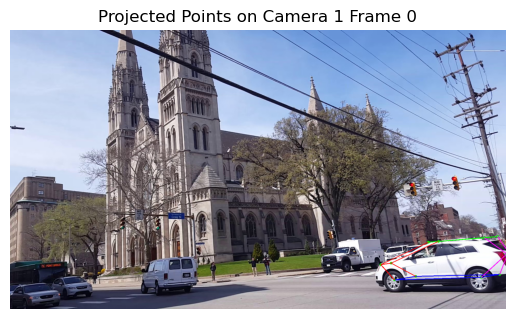

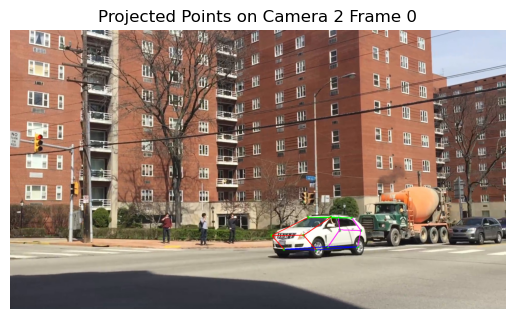

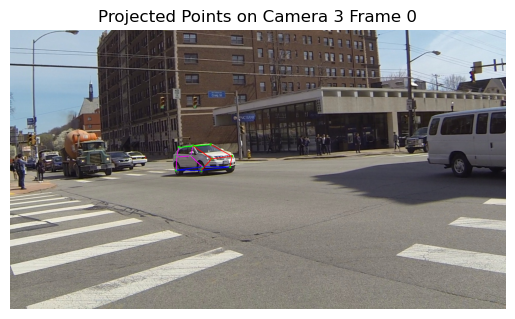

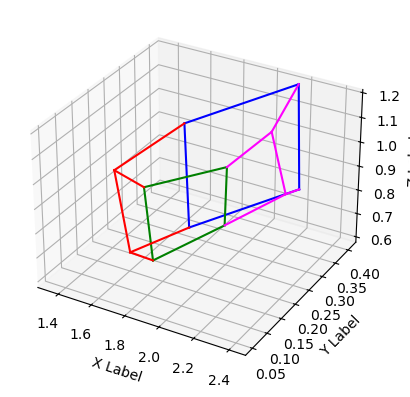

processing time frame - 1
processing time frame - 2
processing time frame - 3
processing time frame - 4
processing time frame - 5
processing time frame - 6
processing time frame - 7
processing time frame - 8
processing time frame - 9


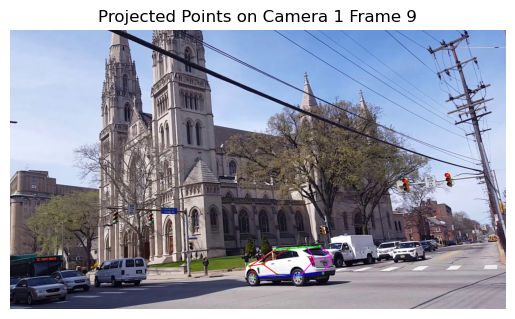

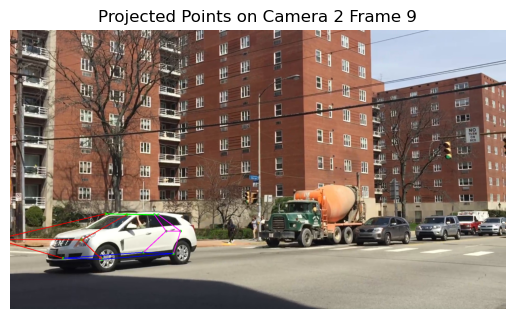

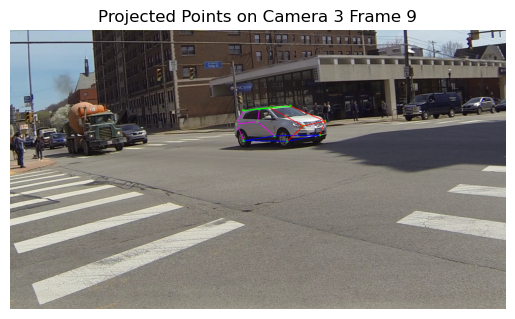

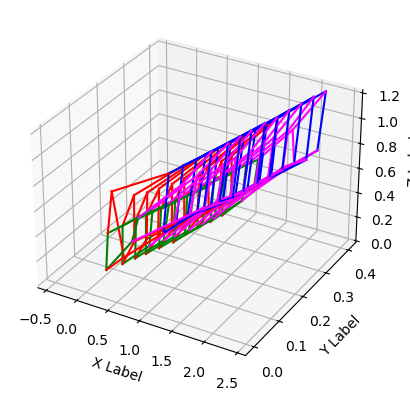

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Assuming `connections_3d` and `colors` are defined as follows:
# Define connections and colors as required by your setup:
connections_3d = [[0,1], [1,3], [2,3], [2,0], [4,5], [6,7], [8,9], [9,11], [10,11], [10,8], [0,4], [4,8],
                  [1,5], [5,9], [2,6], [6,10], [3,7], [7,11]]
colors_rgb = [(255,0,0), (255,0,0), (255,0,0), (255,0,0), (0,0,255), (255,0,255), (0,255,0), (0,255,0), 
              (0,255,0), (0,255,0), (0,0,255), (0,0,255), (0,0,255), (0,0,255), (255,0,255), (255,0,255), 
              (255,0,255), (255,0,255)]  # RGB format colors matching matplotlib plot

pts_3d_video = []
for loop in range(10):
    print(f"processing time frame - {loop}")

    # Load paths for data and images
    data_path = os.path.join('data/q6/', 'time' + str(loop) + '.npz')
    image1_path = os.path.join('data/q6/', 'cam1_time' + str(loop) + '.jpg')
    image2_path = os.path.join('data/q6/', 'cam2_time' + str(loop) + '.jpg')
    image3_path = os.path.join('data/q6/', 'cam3_time' + str(loop) + '.jpg')

    # Load images (convert to writable copies)
    im1 = plt.imread(image1_path).copy()
    im2 = plt.imread(image2_path).copy()
    im3 = plt.imread(image3_path).copy()

    # Load data
    data = np.load(data_path)
    pts1 = data['pts1']
    pts2 = data['pts2']
    pts3 = data['pts3']
    K1, K2, K3 = data['K1'], data['K2'], data['K3']
    M1, M2, M3 = data['M1'], data['M2'], data['M3']

    # Visualize keypoints on the second camera at specific frames
    if loop == 0 or loop == 9:
        img = visualize_keypoints(im2, pts2)

    # ------- YOUR CODE HERE -------
    # Compute the camera matrices for each camera
    C1 = K1 @ M1
    C2 = K2 @ M2
    C3 = K3 @ M3

    # Perform Multi-View Reconstruction with a confidence threshold (e.g., 100)
    pts_3d, err = MultiviewReconstruction(C1, pts1, C2, pts2, C3, pts3, Thres=100)

    # Append the reconstructed points to the video list
    pts_3d_video.append(pts_3d)

    # Project 3D points back onto the images
    P_homogeneous = np.hstack((pts_3d, np.ones((pts_3d.shape[0], 1))))  # Convert to homogeneous coordinates

    # Project onto each camera
    pts1_proj = (C1 @ P_homogeneous.T).T
    pts2_proj = (C2 @ P_homogeneous.T).T
    pts3_proj = (C3 @ P_homogeneous.T).T

    # Convert to 2D (from homogeneous coordinates)
    pts1_proj = (pts1_proj[:, :2] / pts1_proj[:, 2, np.newaxis]).astype(int)
    pts2_proj = (pts2_proj[:, :2] / pts2_proj[:, 2, np.newaxis]).astype(int)
    pts3_proj = (pts3_proj[:, :2] / pts3_proj[:, 2, np.newaxis]).astype(int)

    # Overlay the projected points on the original images and draw edges
    for (x, y) in pts1_proj:
        cv2.circle(im1, (x, y), 5, (0, 255, 0), -1)  # Green for projected points
    for (x, y) in pts2_proj:
        cv2.circle(im2, (x, y), 5, (0, 255, 0), -1)
    for (x, y) in pts3_proj:
        cv2.circle(im3, (x, y), 5, (0, 255, 0), -1)

    # Draw edges on each image with the same colors as in the 3D plot
    for j, (index0, index1) in enumerate(connections_3d):
        # Get color as a tuple of integers (OpenCV expects BGR format)
        color_rgb = colors_rgb[j]
        bgr_color = (int(color_rgb[2]), int(color_rgb[1]), int(color_rgb[0]))

        # Draw line for each pair of points on each image
        cv2.line(im1, tuple(pts1_proj[index0]), tuple(pts1_proj[index1]), bgr_color, 2)
        cv2.line(im2, tuple(pts2_proj[index0]), tuple(pts2_proj[index1]), bgr_color, 2)
        cv2.line(im3, tuple(pts3_proj[index0]), tuple(pts3_proj[index1]), bgr_color, 2)

    # Show the images with projected points and edges
    if loop == 0 or loop == 9:
        plt.figure()
        plt.imshow(im1)
        plt.title(f"Projected Points on Camera 1 Frame {loop}")
        plt.axis('off')
        plt.show()

        plt.figure()
        plt.imshow(im2)
        plt.title(f"Projected Points on Camera 2 Frame {loop}")
        plt.axis('off')
        plt.show()

        plt.figure()
        plt.imshow(im3)
        plt.title(f"Projected Points on Camera 3 Frame {loop}")
        plt.axis('off')
        plt.show()

    # If it's the first frame, visualize the reconstructed 3D points
    if loop == 0:
        plot_3d_keypoint(pts_3d)
    # ------- END YOUR CODE -------

# Visualize the 3D points across all frames in the video
plot_3d_keypoint_video(pts_3d_video)